<a href="https://colab.research.google.com/github/Ajah-Stephen/MSCPROJECT/blob/main/MSCPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta joblib scikeras
!pip install tensorflow


## 1. DATA COLLECTION AND PREPROCESSING

## 1.1 Import Libraries

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import yfinance as yf

In [ ]:
# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import plot_model
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from keras.regularizers import l2

In [ ]:
# SciPy and Statsmodels
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Scikit-learn
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Technical Analysis Indicators
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
from ta.volatility import BollingerBands

### 1.2 Data Collection

Fetch historical stock data for Rolls-Royce Holdings (e.g., using APIs from Yahoo Finance or other financial data providers).

In [ ]:
# Fetch historical stock data for Rolls-Royce Holdings
ticker = 'RR.L'  # Rolls-Royce Holdings ticker symbol
start_date = '1992-12-01'
end_date = '2026-01-01'

# Download data using yfinance
rolls = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
rolls.reset_index(inplace=True)
rolls['Date'] = pd.to_datetime(rolls['Date'])
rolls.set_index('Date', inplace=True)

In [ ]:
rolls.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-12-01,30.946600,30.946600,30.946600,30.946600,14.471504,20682545
1992-12-02,31.552601,31.552601,31.552601,31.552601,14.754890,13678048
1992-12-03,32.613201,32.613201,32.613201,32.613201,15.250856,19553081
1992-12-04,31.855600,31.855600,31.855600,31.855600,14.896578,25030373
1992-12-07,30.946600,30.946600,30.946600,30.946600,14.471504,8143069


### 1.3 DATA CLEANING AND PREPROCESSING

In [ ]:
# Displaying the first few rows of the dataframe to understand its structure
print(rolls.head())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
1992-12-01  30.946600  30.946600  30.946600  30.946600  14.471504  20682545
1992-12-02  31.552601  31.552601  31.552601  31.552601  14.754890  13678048
1992-12-03  32.613201  32.613201  32.613201  32.613201  15.250856  19553081
1992-12-04  31.855600  31.855600  31.855600  31.855600  14.896578  25030373
1992-12-07  30.946600  30.946600  30.946600  30.946600  14.471504   8143069


In [ ]:
rolls.dtypes

,0
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [ ]:
# Checking for missing values
missing_values = rolls.isnull().sum()
missing_values

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
rolls.shape

(8128, 6)

### 2 APPLYING EXPLORATORY DATA ANALYSIS (EDA) AND VISUALIZATION

2.1 GETTING THE HEATMAP CORRELATION

In [ ]:
# Calculating the Correlation Matrix
rolls.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999615,0.999721,0.999572,0.992028,-0.112666
High,0.999615,1.000000,0.999442,0.999647,0.992486,-0.108332
Low,0.999721,0.999442,1.000000,0.999724,0.991702,-0.115726
Close,0.999572,0.999647,0.999724,1.000000,0.992382,-0.111464
Adj Close,0.992028,0.992486,0.991702,0.992382,1.000000,-0.093288
Volume,-0.112666,-0.108332,-0.115726,-0.111464,-0.093288,1.000000


In [ ]:
# Calculating additional statistics
print(f"Number of trading days: {len(rolls)}")
print(f"Date range: {rolls.index.min()} to {rolls.index.max()}")
print(f"Total trading volume: {rolls['Volume'].sum():,}")

Number of trading days: 8128
Date range: 1992-12-01 00:00:00 to 2024-08-29 00:00:00
Total trading volume: 217,271,905,924


In [ ]:
# Calculating the Correlation Matrix
rolls.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999615,0.999721,0.999572,0.992028,-0.112666
High,0.999615,1.000000,0.999442,0.999647,0.992486,-0.108332
Low,0.999721,0.999442,1.000000,0.999724,0.991702,-0.115726
Close,0.999572,0.999647,0.999724,1.000000,0.992382,-0.111464
Adj Close,0.992028,0.992486,0.991702,0.992382,1.000000,-0.093288
Volume,-0.112666,-0.108332,-0.115726,-0.111464,-0.093288,1.000000


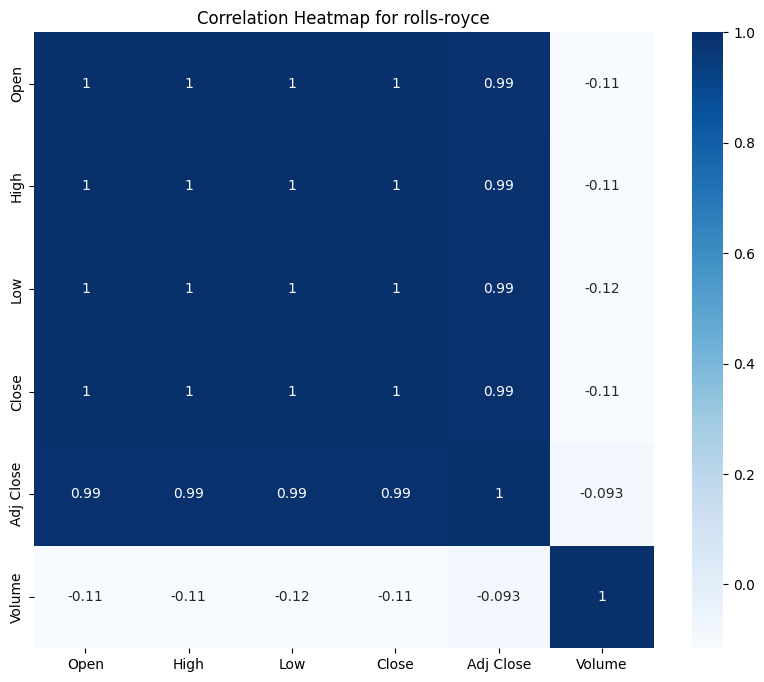

In [ ]:
# Ploting Heatmap for rolls.corr
plt.figure(figsize=(10, 8))
sns.heatmap(rolls.corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap for rolls-royce')
plt.show()

### 2.2 PLOTTING VISUALIZATION

2.3 Plotting Visualization for stock Price Over Years (volume)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')



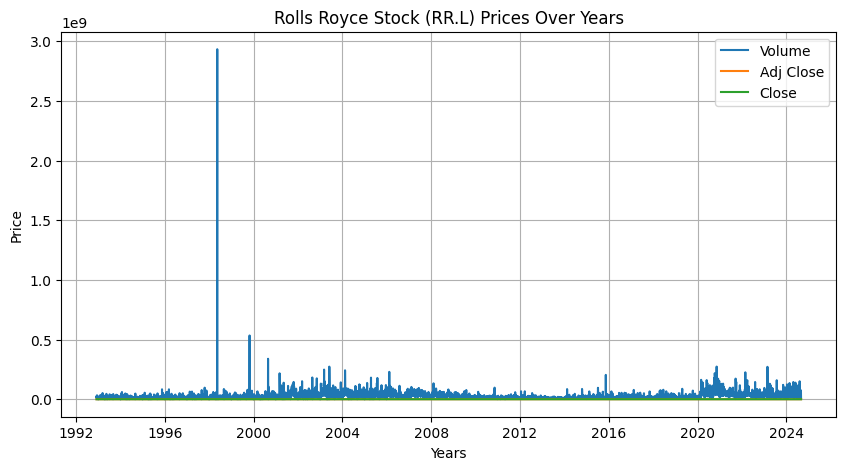

In [ ]:
print(rolls.columns)

# Plotting visualization for stock price over years
if 'Date' not in rolls.columns:
    # List potential date column names
    potential_date_columns = ['Trade Date', 'Date Time', 'Transaction Date']

    # Finding the correct date column and rename it
    for col in potential_date_columns:
        if col in rolls.columns:
            rolls = rolls.rename(columns={col: 'Date'})
            print(f"Renamed '{col}' to 'Date'")
            break
    else:
        print()

# Plot time series of stock prices
plt.figure(figsize=(10, 5))
plt.plot(rolls.index, rolls['Volume'], label='Volume')
plt.plot(rolls.index, rolls['Adj Close'], label='Adj Close')
plt.plot(rolls.index, rolls['Close'], label='Close')
plt.title('Rolls Royce Stock (RR.L) Prices Over Years')
plt.xlabel('Years')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

This chart provides a detailed overview of Rolls-Royce's stock performance over time, highlighting both price and trading volume. The spikes in volume are particularly significant, as they often align with major events in the company's history. The close and adjusted close lines offer a clear depiction of the stock's value, with the adjusted close offering a more accurate reflection of investor returns by accounting for dividends and stock splits.

### 2.4 LOOKING CLOSELY AT THE CLOSE PRICE PRICE OVER THE YEARS

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


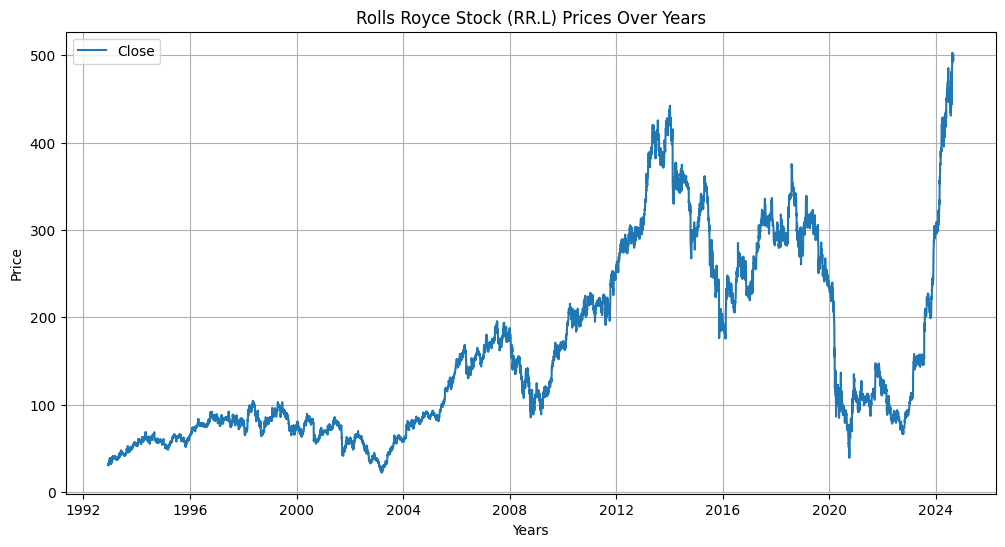

In [ ]:
# Plot time series of stock prices
print(rolls.columns)
plt.figure(figsize=(12, 6))
plt.plot(rolls.index, rolls['Close'], label='Close')
plt.title('Rolls Royce Stock (RR.L) Prices Over Years')
plt.xlabel('Years')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

The COVID-19 pandemic severely impacted Rolls-Royce, primarily due to the downturn in the aviation industry. The company encountered significant financial challenges, resulting in a sharp decline in its stock price in 2020. However, through recovery efforts and the gradual return of air travel, Rolls-Royce's situation began to improve as reflected in the subsequent rise in its stock price.

### 2.5 CALCULATING THE STATISTICS

### 2.5.1 Plotting Visualization for Daily Returns

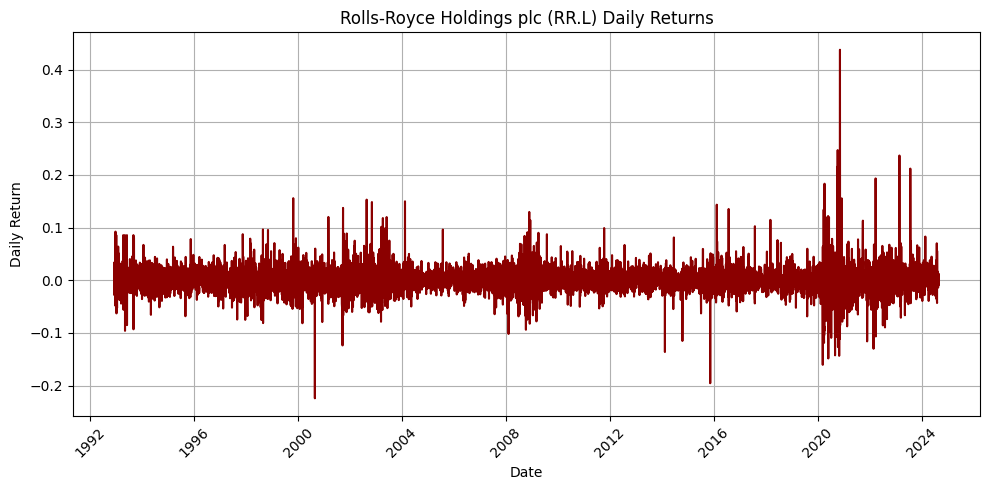

In [ ]:
# Calculating daily returns
rolls['Daily_Return'] = rolls['Adj Close'].pct_change()
# Plotting daily returns
plt.figure(figsize=(10, 5))
plt.plot(rolls.index, rolls['Daily_Return'], color='darkred')
plt.title('Rolls-Royce Holdings plc (RR.L) Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

illustration of daily returns of Rolls-Royce Holdings plc over a period spanning from the early 1992 to 2024. Daily returns represent the percentage change in stock price from one day to the next and are a measure of volatility

### 3 FEATURE ENGINEERING

3.1 Creating and Adding New Features to Dataframe (Moving Averages, Exponential moving averages,RSI, Bollinger Bands. to identify trends of prices

In [ ]:
# Exponential Moving Averages (EMA)
rolls['EMA_12'] = rolls['Close'].ewm(span=12, adjust=False).mean()
rolls['EMA_26'] = rolls['Close'].ewm(span=26, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
close = rolls['Close']
delta = close.diff()
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
roll_up = up.rolling(window_length).mean()
roll_down = down.abs().rolling(window_length).mean()
rs = roll_up / roll_down
rolls['RSI'] = 100.0 - (100.0 / (1.0 + rs))

# Bollinger Bands (BBM only)
window = 20
rolling_mean = rolls['Close'].rolling(window).mean()
rolls['BBM'] = rolling_mean  # Middle Band (BBM)

# Display the first few rows of the dataframe with new indicators
#print(rolls[['Close', 'EMA_12', 'EMA_26', 'RSI', 'BBM']].head())


In [ ]:
# Displaying summary statistics of the new features
print("Summary statistics of the new engineered features:")
rolls.describe()

Summary statistics of the new engineered features:


,Open,High,Low,Close,Adj Close,Volume,Daily_Return,EMA_12,EMA_26,RSI,BBM
count,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8.128000e+03,8127.000000,8128.000000,8128.000000,8114.000000,8109.000000
mean,160.038682,162.141373,157.889032,160.052018,137.646717,2.673129e+07,0.000739,159.738779,159.356880,51.598186,159.810034
std,106.811315,107.766386,105.762808,106.807688,109.705188,4.042989e+07,0.024796,106.330965,105.780297,16.315142,106.031759
min,23.163799,23.678600,22.048500,22.048500,14.186577,0.000000e+00,-0.224256,24.753171,26.720025,3.349053,25.750425
25%,75.325401,76.526497,73.879801,75.389751,42.744030,1.145445e+07,-0.010638,75.603799,75.608672,40.050746,75.797235
50%,115.304497,117.674999,112.473297,115.132896,103.440002,1.934668e+07,0.000000,114.726075,113.241166,52.143823,114.450830
75%,238.596222,241.538872,235.395897,239.016602,226.041157,3.369644e+07,0.011317,237.015309,237.476224,63.174159,238.055709
max,504.000000,505.000000,498.000000,503.000000,503.000000,2.934018e+09,0.437608,493.856808,482.953510,100.000000,487.860002


### 3.2 Plotting Visualization to Include Additional Feature Engineering Created

In [ ]:
# Exponential Moving Averages (EMA)
rolls['EMA_12'] = rolls['Close'].ewm(span=12, adjust=False).mean()
rolls['EMA_26'] = rolls['Close'].ewm(span=26, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 10
close = rolls['Close']
delta = close.diff()
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
roll_up = up.rolling(window_length).mean()
roll_down = down.abs().rolling(window_length).mean()
rs = roll_up / roll_down
rolls['RSI'] = 100.0 - (100.0 / (1.0 + rs))

# Bollinger Bands (BBM only)
window = 20
rolling_mean = rolls['Close'].rolling(window).mean()
rolls['BBM'] = rolling_mean  # Middle Band (BBM)

# Display the first few rows of the dataframe with new indicators
print(rolls[['Close', 'EMA_12', 'EMA_26', 'RSI', 'BBM']].head())


                Close     EMA_12     EMA_26  RSI  BBM
Date                                                 
1992-12-01  30.946600  30.946600  30.946600  NaN  NaN
1992-12-02  31.552601  31.039831  30.991489  NaN  NaN
1992-12-03  32.613201  31.281888  31.111616  NaN  NaN
1992-12-04  31.855600  31.370151  31.166726  NaN  NaN
1992-12-07  30.946600  31.304990  31.150420  NaN  NaN


### 3.3 STOCK PRICE INDICATORS

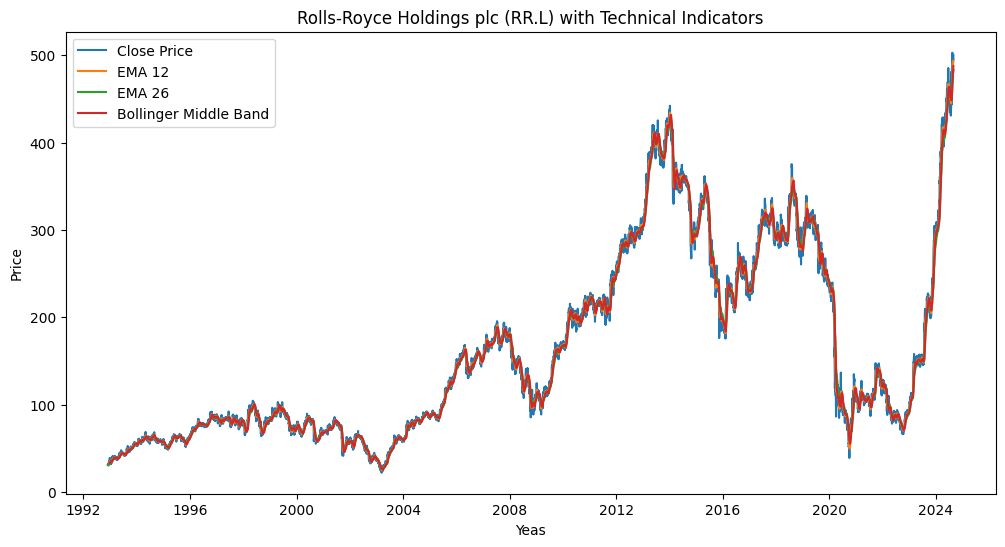

In [ ]:
# Plot the stock price with new indicators
plt.figure(figsize=(12, 6))
plt.plot(rolls.index, rolls['Close'], label='Close Price')
plt.plot(rolls.index, rolls['EMA_12'], label='EMA 12')
plt.plot(rolls.index, rolls['EMA_26'], label='EMA 26')
plt.plot(rolls.index, rolls['BBM'], label='Bollinger Middle Band')
plt.title('Rolls-Royce Holdings plc (RR.L) with Technical Indicators')
plt.xlabel('Yeas')
plt.ylabel('Price')
plt.legend()
plt.show()


### 3.4 RSI indicator

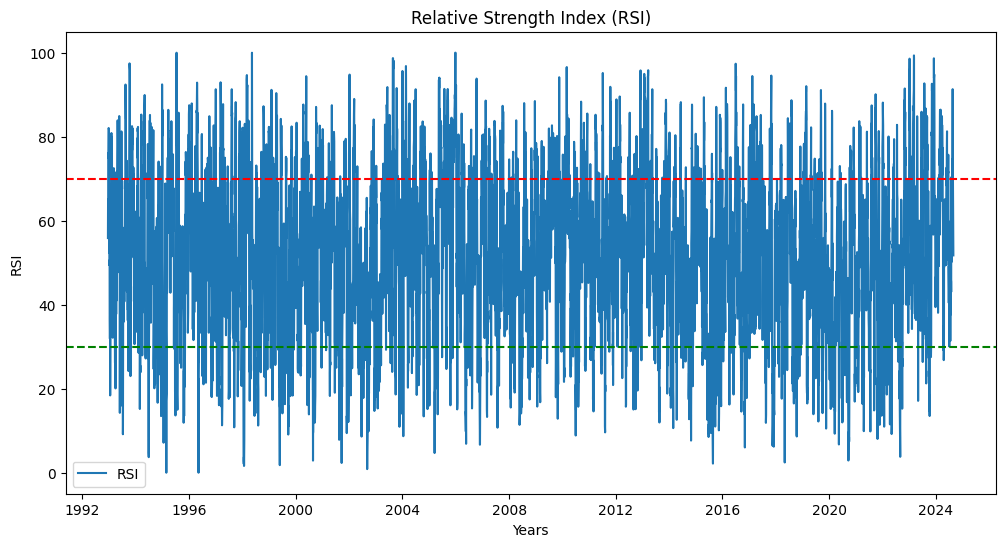

In [ ]:
# Plot RSI
plt.figure(figsize=(12, 6))
plt.plot(rolls.index, rolls['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Years')
plt.ylabel('RSI')
plt.legend()
plt.show()

### 4 APPLYING TIME SERIES ANALYSIS


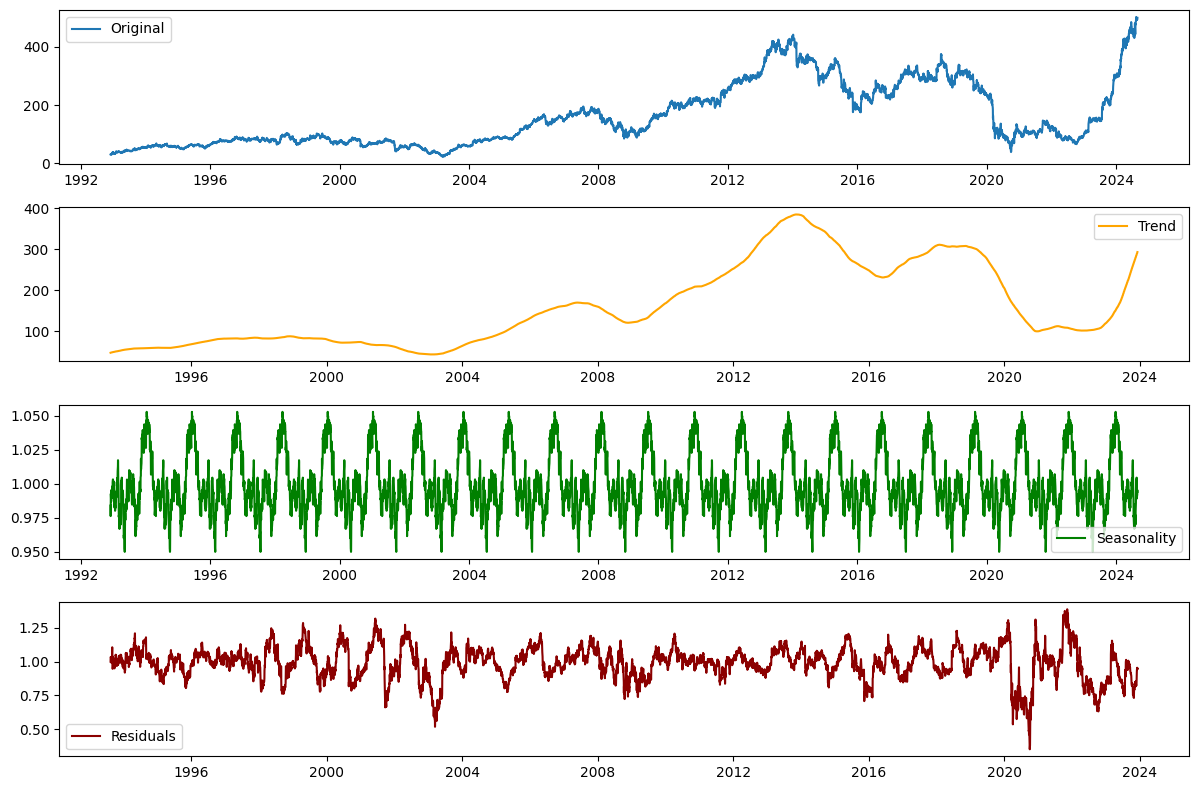

In [ ]:
# Decompose the Time Series
decomposition = sm.tsa.seasonal_decompose(rolls['Close'], model='multiplicative', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting Decomposed Components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(rolls['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkred')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
# Handling missing data
rolls.dropna(inplace=True)

In [ ]:
rolls.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Daily_Return,0
EMA_12,0
EMA_26,0
RSI,0


In [ ]:
# Dropping highly columns
rolls = rolls.drop(columns=[col for col in ['Open', 'High', 'Low', 'Adj Close'] if col in rolls.columns])

In [ ]:
# Calculating the Correlation Matrix
rolls.corr()

,Close,Volume,Daily_Return,EMA_12,EMA_26,RSI,BBM
Close,1.000000,-0.112581,0.010999,0.998617,0.996648,0.053303,0.996687
Volume,-0.112581,1.000000,0.071232,-0.114470,-0.114810,0.029155,-0.114884
Daily_Return,0.010999,0.071232,1.000000,-0.011915,-0.014043,0.265260,-0.014512
EMA_12,0.998617,-0.114470,-0.011915,1.000000,0.999270,0.016818,0.999400
EMA_26,0.996648,-0.114810,-0.014043,0.999270,1.000000,-0.001453,0.999770
RSI,0.053303,0.029155,0.265260,0.016818,-0.001453,1.000000,-0.005158
BBM,0.996687,-0.114884,-0.014512,0.999400,0.999770,-0.005158,1.000000


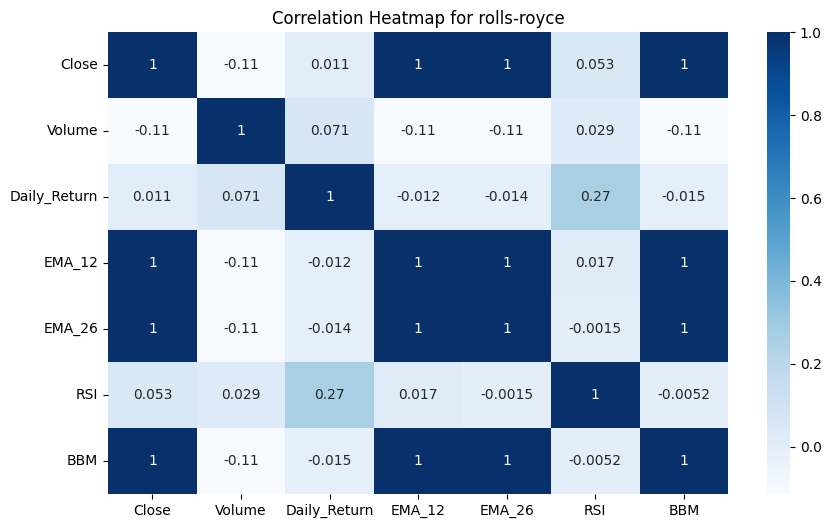

In [ ]:
# Ploting Heatmap for rolls.corr
plt.figure(figsize=(10, 6))
sns.heatmap(rolls.corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap for rolls-royce')
plt.show()

###   5 Applying Linear Regression Model

Mean Squared Error: 32086.5854164758
Mean Absolute Error: 150.56963764178914
Root Mean Squared Error: 179.12728830771653
Mean Absolute Percentage Error: 134.95%
The R-squared (R2) is: -1.53


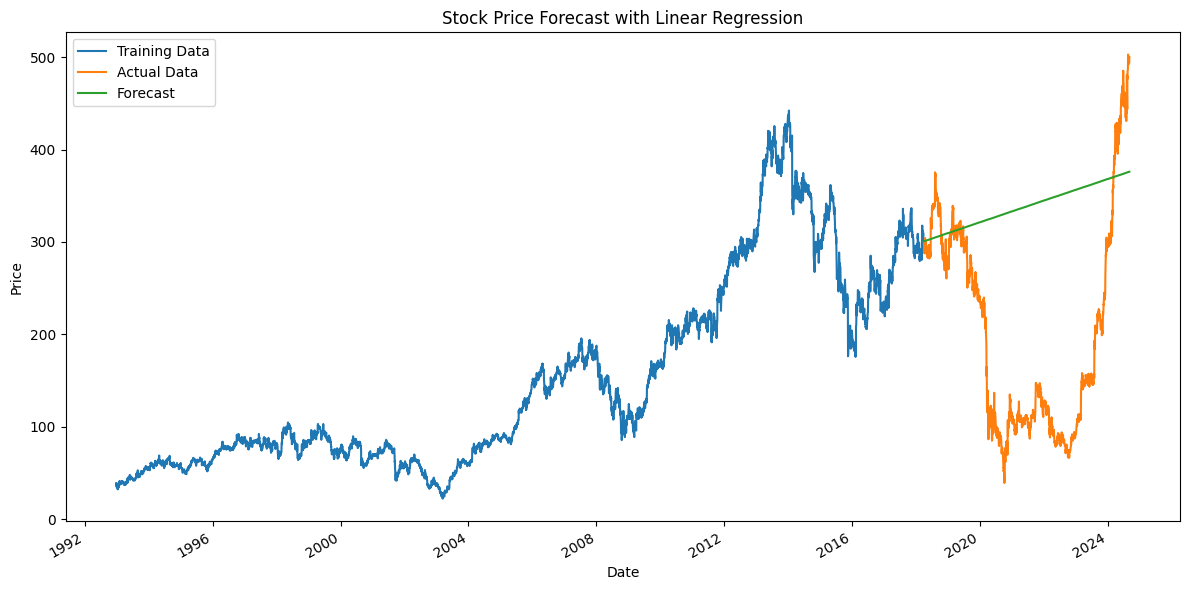

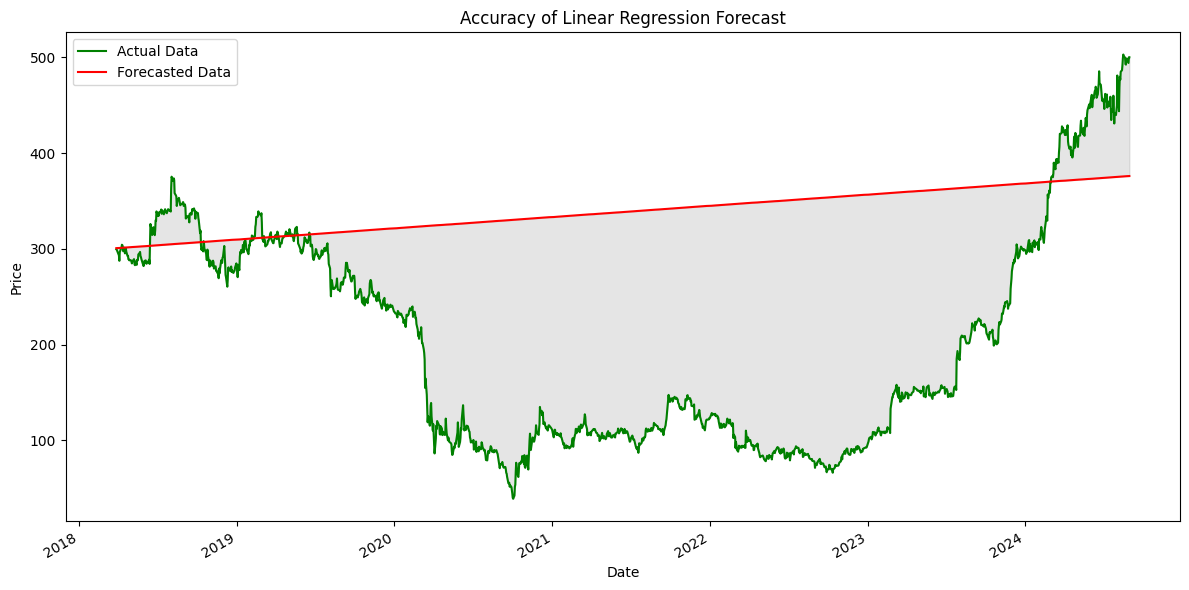

In [ ]:
# Split the data into training and test sets
split_index = int(len(rolls) * 0.8)
split_date = rolls.index[split_index]
train = rolls.loc[:split_date]
test = rolls.loc[split_date + pd.Timedelta(days=1):]

# Linear Regression Model Class
class LinearRegressionModel:
    def __init__(self, train, test, target_column):
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column

        # Extract the target column
        self.train_y = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test_y = pd.to_numeric(test[target_column], errors='coerce').dropna()

        # Reshape the target column to use as a feature (for univariate linear regression)
        self.train_X = np.arange(len(self.train_y)).reshape(-1, 1)
        self.test_X = np.arange(len(self.train_y), len(self.train_y) + len(self.test_y)).reshape(-1, 1)

        self.model = None
        self.predictions = None

    @staticmethod
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_mask = y_true != 0
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    def fit_model(self):
        self.model = LinearRegression()
        self.model.fit(self.train_X, self.train_y)

    def make_forecast(self):
        if self.model is None:
            raise ValueError("Model not fitted. Please run fit_model first.")
        self.predictions = self.model.predict(self.test_X)

    def plot_results(self):
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.train_y.index, self.train_y, label='Training Data')
        plt.plot(self.test_y.index, self.test_y, label='Actual Data')
        plt.plot(self.test_y.index, self.predictions, label='Forecast')
        plt.legend()

        plt.title('Stock Price Forecast with Linear Regression')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test_y.index, self.test_y, label='Actual Data', color='green')
        plt.plot(self.test_y.index, self.predictions, label='Forecasted Data', color='red')
        plt.fill_between(self.test_y.index, self.test_y, self.predictions, color='grey', alpha=0.2)
        plt.legend()
        plt.title('Accuracy of Linear Regression Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test_y, self.predictions)
        mae = mean_absolute_error(self.test_y, self.predictions)
        rmse = np.sqrt(mse)
        mape = self.mean_absolute_percentage_error(self.test_y, self.predictions)
        r2 = r2_score(self.test_y, self.predictions)

        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Squared Error: {rmse}")
        print(f"Mean Absolute Percentage Error: {mape:.2f}%")
        print(f"The R-squared (R2) is: {r2:.2f}")

    def get_forecast(self):
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.predictions

# Instantiate and run the LinearRegressionModel
model = LinearRegressionModel(train, test, target_column='Close')
model.fit_model()
model.make_forecast()
model.print_evaluation_metrics()
model.plot_results()
model.plot_accuracy()

### 6 RANDOM FOREST

In [ ]:
class RandomForestModel:
    def __init__(self, train, test, target_column='Close', lags=3, rolling_window=3):
        """
        Initializes the RandomForestModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for Random Forest modeling.
        lags (int): Number of lag features to create.
        rolling_window (int): Size of the rolling window for statistics.
        """
        self.target_column = target_column
        self.lags = lags
        self.rolling_window = rolling_window

        # Create lag features and rolling statistics
        self.train = self.create_features(train)
        self.test = self.create_features(test)

        self.train_X = self.train.drop(columns=[target_column])
        self.train_y = self.train[target_column]
        self.test_X = self.test.drop(columns=[target_column])
        self.test_y = self.test[target_column]

        self.model = None
        self.predictions = None
        self.best_params_ = None

    def create_features(self, df):
        """
        Create lag features and rolling statistics for the dataset.

        Parameters:
        df (pd.DataFrame): The dataframe to create features on.

        Returns:
        pd.DataFrame: DataFrame with new features.
        """
        data = df.copy()
        # Create lag features
        for lag in range(1, self.lags + 1):
            data[f'lag_{lag}'] = data[self.target_column].shift(lag)

        # Create rolling statistics
        data[f'rolling_mean_{self.rolling_window}'] = data[self.target_column].rolling(window=self.rolling_window).mean()
        data[f'rolling_std_{self.rolling_window}'] = data[self.target_column].rolling(window=self.rolling_window).std()

        # Drop rows with NaN values caused by shifting
        data = data.dropna()

        return data

    def mean_absolute_percentage_error(self, y_true, y_pred):
        """
        Calculate the mean absolute percentage error.
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_mask = y_true != 0
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    def fit_model(self):
        """
        Fits the Random Forest model to the training data with hyperparameter tuning.
        """
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']
        }

        tscv = TimeSeriesSplit(n_splits=3)
        grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=1)
        grid_search.fit(self.train_X, self.train_y)

        self.model = grid_search.best_estimator_
        self.best_params_ = grid_search.best_params_

        print(f"Best parameters found: {self.best_params_}")

    def make_forecast(self):
        """
        Makes predictions using the fitted Random Forest model.
        """
        if self.model is None:
            raise ValueError("Model not fitted. Please run fit_model first.")
        self.predictions = self.model.predict(self.test_X)

    def plot_results(self):
        """
        Plots the actual and predicted values.
        """
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train_y, label='Training Data', color='blue')
        plt.plot(self.test.index, self.test_y, label='Actual Data', color='green')
        plt.plot(self.test.index, self.predictions, label='Forecast', color='red')
        plt.legend()

        plt.title('Stock Price Forecast with Random Forest')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test_y, label='Actual Data', color='green')
        plt.plot(self.test.index, self.predictions, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test_y, self.predictions, color='grey', alpha=0.2)
        plt.legend()
        plt.title('Accuracy of Random Forest Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test_y, self.predictions)
        mae = mean_absolute_error(self.test_y, self.predictions)
        rmse = np.sqrt(mse)
        mape = self.mean_absolute_percentage_error(self.test_y, self.predictions)
        r2 = r2_score(self.test_y, self.predictions)  # Calculate R-squared

        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Squared Error: {rmse}")
        print(f"Mean Absolute Percentage Error: {mape:.2f}%")
        print(f"R-squared (R2): {r2:.2f}")

    def get_forecast(self):
        """
        Returns the forecast made by the fitted Random Forest model.
        """
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.predictions

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


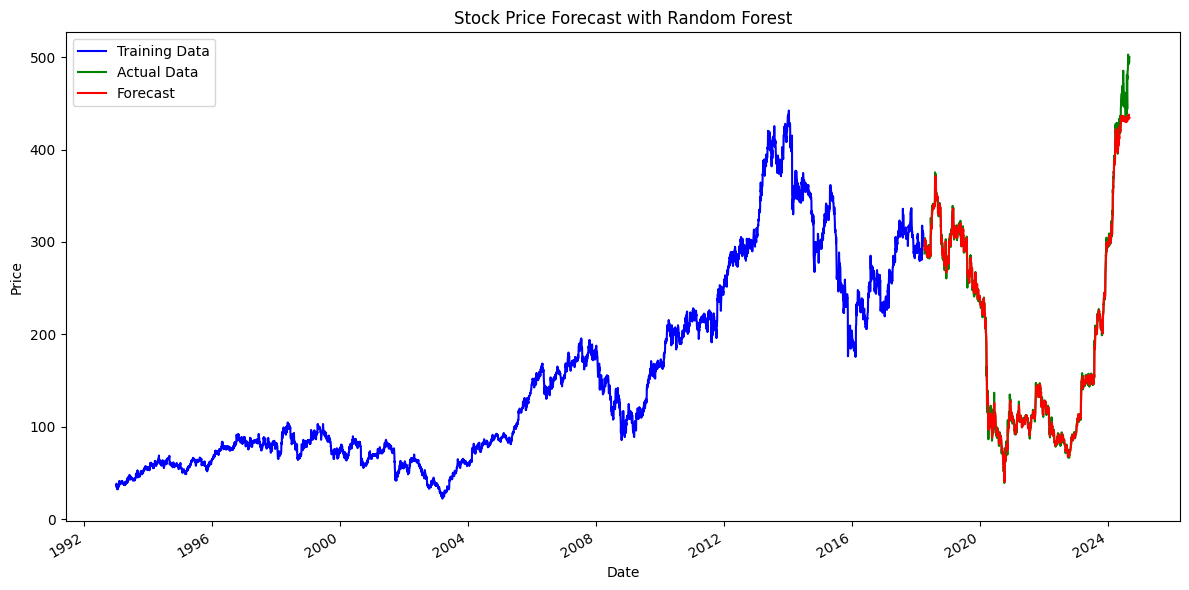

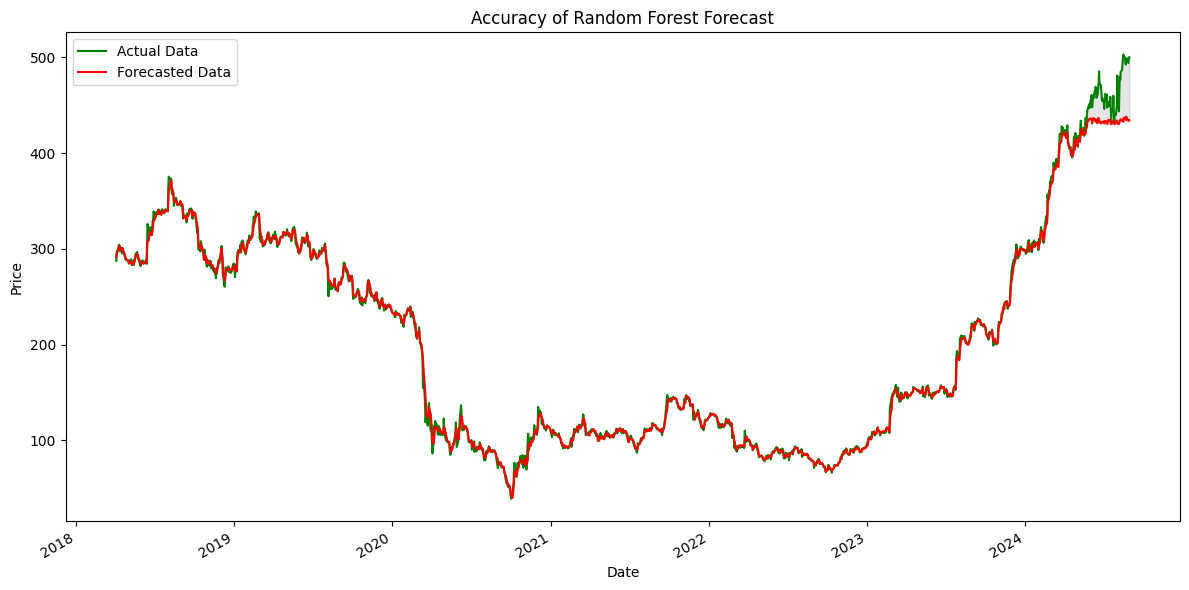

Mean Squared Error: 67.17848975929284
Mean Absolute Error: 3.46657901113228
Root Mean Squared Error: 8.196248517418981
Mean Absolute Percentage Error: 1.66%
R-squared (R2): 0.99


In [ ]:
# Initialize the model
random_forest_model = RandomForestModel(train=train, test=test, target_column='Close')

# Fit the model
random_forest_model.fit_model()

# Make the forecast
random_forest_model.make_forecast()

# Plot the results
random_forest_model.plot_results()

# Plot forecast accuracy
random_forest_model.plot_accuracy()

# Print evaluation metrics, including R-squared
random_forest_model.print_evaluation_metrics()

### 7 Applying Long Short Time Memory (LSTM)

In [ ]:
class EnhancedLSTMModel:
    def __init__(self, train, test, target_column, look_back=10):
        """
        Initializes the EnhancedLSTMModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for LSTM modeling.
        look_back (int): Number of previous time steps to use as input features.
        """
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column
        self.look_back = look_back

        # Scaling the data
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.train_scaled = self.scaler.fit_transform(train[[target_column]])
        self.test_scaled = self.scaler.transform(test[[target_column]])

        # Store the original indices for plotting
        self.train_index = train.index[self.look_back:]
        self.test_index = test.index[self.look_back:]

        # Prepare the data for LSTM
        self.train_X, self.train_y = self.create_dataset(self.train_scaled, self.look_back)
        self.test_X, self.test_y = self.create_dataset(self.test_scaled, self.look_back)

        # Reshape input to be [samples, time steps, features] which is required for LSTM
        self.train_X = np.reshape(self.train_X, (self.train_X.shape[0], self.train_X.shape[1], 1))
        self.test_X = np.reshape(self.test_X, (self.test_X.shape[0], self.test_X.shape[1], 1))

        self.model = None
        self.predictions = None

    def create_dataset(self, dataset, look_back):
        """
        Converts the dataset into X and y datasets for LSTM.

        Parameters:
        dataset (np.array): The dataset to convert.
        look_back (int): Number of previous time steps to use as input features.

        Returns:
        Tuple of np.array: (X, y) datasets.
        """
        X, y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(y)

    def build_model(self):
        """
        Builds the LSTM model.
        """
        self.model = Sequential()

        # Adding the first LSTM layer with Dropout and L2 regularization
        self.model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(self.train_X.shape[1], 1),
                                          kernel_regularizer=l2(0.01))))
        self.model.add(Dropout(0.3))

        # Adding a second LSTM layer with Dropout and L2 regularization
        self.model.add(Bidirectional(LSTM(units=50, return_sequences=False, kernel_regularizer=l2(0.01))))
        self.model.add(Dropout(0.3))

        # Adding the output layer
        self.model.add(Dense(units=1))

        # Compiling the model with the Adam optimizer and a reduced learning rate
        optimizer = Adam(learning_rate=0.001)
        self.model.compile(optimizer=optimizer, loss='mean_squared_error')

    def fit_model(self, epochs=50, batch_size=16):
        """
        Fits the LSTM model to the training data.

        Parameters:
        epochs (int): Number of epochs to train the model.
        batch_size (int): Batch size used in the training.
        """
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        self.model.fit(self.train_X, self.train_y, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

    def make_forecast(self):
        """
        Makes predictions using the fitted LSTM model.
        """
        if self.model is None:
            raise ValueError("Model not built. Please run build_model and fit_model first.")
        self.predictions = self.model.predict(self.test_X)
        self.predictions = self.scaler.inverse_transform(self.predictions)

    def plot_results(self):
        """
        Plots the actual and predicted values.
        """
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.train_index, self.scaler.inverse_transform(self.train_scaled[self.look_back:]), label='Training Data', color='blue')
        plt.plot(self.test_index, self.scaler.inverse_transform(self.test_scaled[self.look_back:]), label='Actual Data', color='green')
        plt.plot(self.test_index, self.predictions, label='Forecast', color='red')
        plt.legend()

        plt.title('Stock Price Forecast with Enhanced LSTM')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        # Convert scaled data back to original scale and flatten to 1D
        actual_data = self.scaler.inverse_transform(self.test_scaled[self.look_back:]).flatten()
        forecasted_data = self.predictions.flatten()

        plt.figure(figsize=(12, 6))
        plt.plot(self.test_index, actual_data, label='Actual Data', color='green')
        plt.plot(self.test_index, forecasted_data, label='Forecasted Data', color='red')
        plt.fill_between(self.test_index, actual_data, forecasted_data, color='grey', alpha=0.2)
        plt.legend()
        plt.title('Accuracy of Enhanced LSTM Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        # Inverse transform the test_y for evaluation
        test_y_inverse = self.scaler.inverse_transform(self.test_y.reshape(-1, 1))

        mse = mean_squared_error(test_y_inverse, self.predictions)
        mae = mean_absolute_error(test_y_inverse, self.predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_y_inverse, self.predictions)

        # Calculate MAPE with epsilon to avoid division by zero
        epsilon = 1e-10  # small value to prevent division by zero
        mape = np.mean(np.abs((test_y_inverse - self.predictions) / (test_y_inverse + epsilon))) * 100

        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Squared Error: {rmse}")
        print(f"The R-squared (R2) is: {round(r2 * 100)}%")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    def get_forecast(self):
        """
        Returns the forecast made by the fitted LSTM model.
        """
        if self.predictions is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.predictions

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 0.9400 - val_loss: 0.0028
Epoch 2/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0015 - val_loss: 0.0075
Epoch 4/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 5/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 6/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0014 - val_loss: 0.0079
Epoch 7/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0013 - val_loss: 0.0140
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


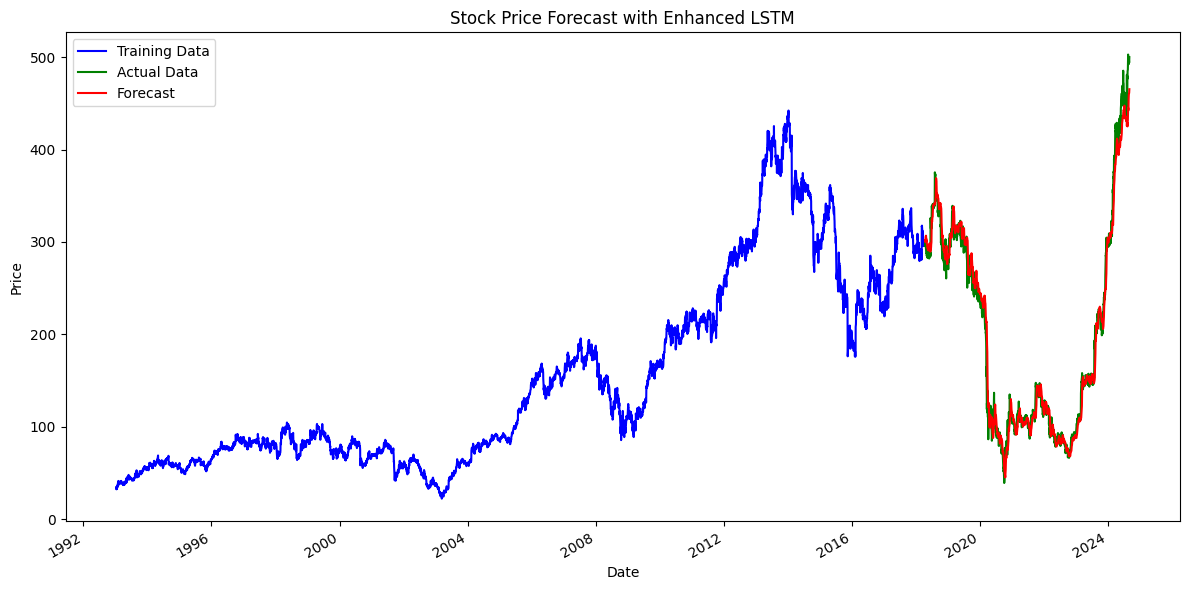

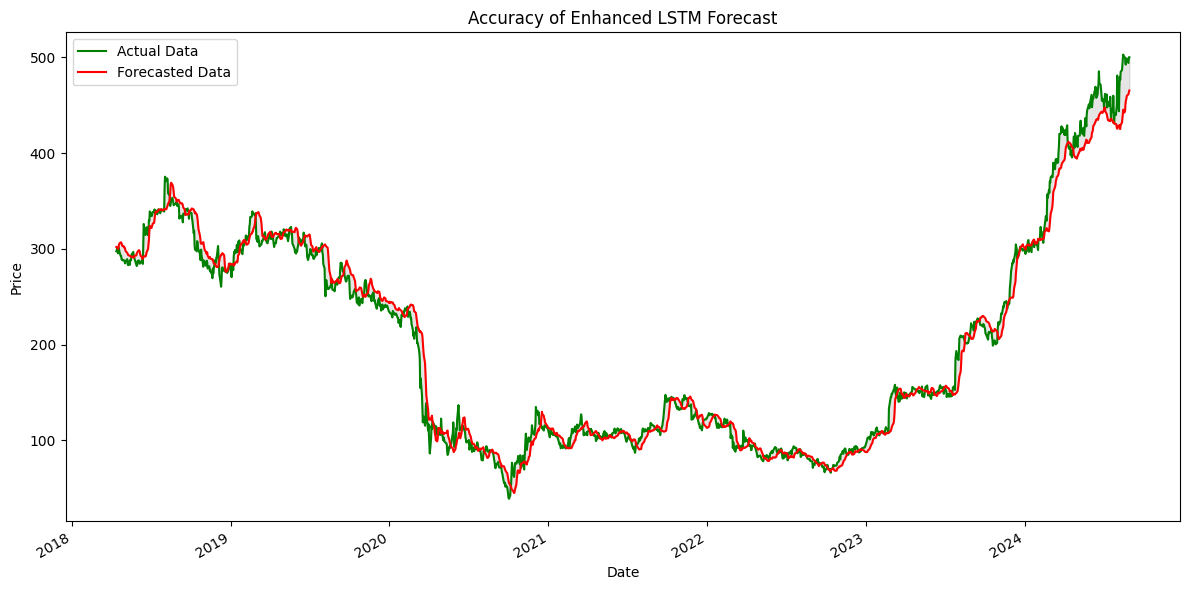

Mean Squared Error: 225.90286427231274
Mean Absolute Error: 10.59061037865135
Root Mean Squared Error: 15.030065344911604
The R-squared (R2) is: 98%
Mean Absolute Percentage Error (MAPE): 6.07%


In [ ]:
# Initialize the model
lstm_model = EnhancedLSTMModel(train=train, test=test, target_column='Close')

# Build the model
lstm_model.build_model()

# Fit the model
lstm_model.fit_model(epochs=50, batch_size=16)

# Make the forecast
lstm_model.make_forecast()

# Plot the results
lstm_model.plot_results()

# Plot forecast accuracy
lstm_model.plot_accuracy()

# Print evaluation metrics
lstm_model.print_evaluation_metrics()